In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'retina'

# Getting Started

In this notebook, we'll use a simple mask and correct for mode coupling.

In [2]:
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot

import nawrapper as nw
import nawrapper.maputils as maputils

Let's generate a random map to try doing analysis on.

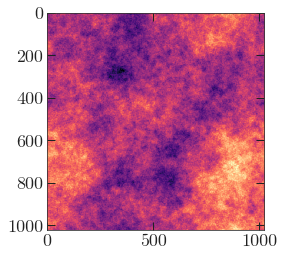

In [3]:
shape,wcs = enmap.geometry(shape=(1024,1024),
                           res=np.deg2rad(0.5/60.),pos=(0,0))
ells = np.arange(0,6000,1)
ps = np.zeros(len(ells))
ps[2:] = 1/ells[2:]**2.5 # don't want monopole/dipole
imap = enmap.rand_map(shape,wcs,ps[np.newaxis,np.newaxis])
plt.imshow(imap)

Next, let's generate a point source map. We'll add these sources to the map, and apodize to generate a mask.

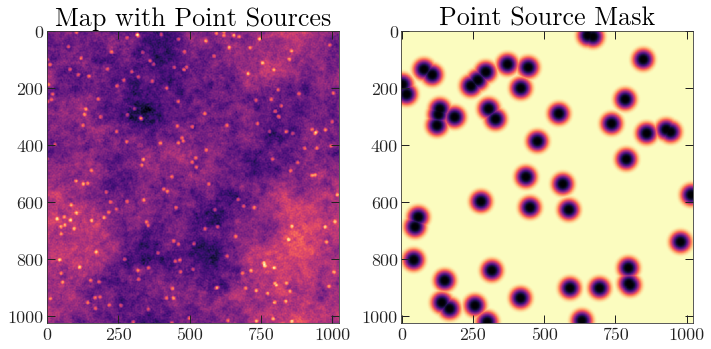

In [7]:
mask = enmap.ones(imap.shape, imap.wcs)

N_point_sources = 50
for i in range(N_point_sources):
    mask[ 
        np.random.randint(low=0, high=mask.shape[0]), 
        np.random.randint(low=0, high=mask.shape[1]) ] = 0

point_source_map = 1-maputils.apod_C2(mask, 0.1)
imap += point_source_map
mask = maputils.apod_C2(mask, 0.5)

fig, axes = plt.subplots(1, 2, figsize=(10,20))

axes[0].imshow(imap)
axes[1].imshow(mask)
axes[0].set_title('Map with Point Sources')
axes[1].set_title('Point Source Mask')
plt.tight_layout()

Now let's do two noise realizations.

Text(0.5, 0, 'Multipole $\\ell$')

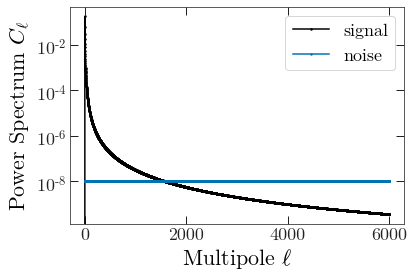

In [14]:
ells = np.arange(0,len(ps),1)
nl = np.ones(len(ells)) * 1e-8

plt.figure(figsize=(6,4))
plt.plot(ps, label="signal")
plt.plot(nl, label="noise")
plt.yscale('log')
plt.legend()
plt.ylabel(r'Power Spectrum $C_{\ell}$')
plt.xlabel(r'Multipole $\ell$')

In [6]:
noise_map_1 = enmap.rand_map(shape, wcs,
                             nl[np.newaxis, np.newaxis])
noise_map_2 = enmap.rand_map(shape, wcs,
                             nl[np.newaxis, np.newaxis])

For this example we won't include a beam. Let's set up the namap objects.

# The Power Spectrum Part

In [7]:
namap_1 = nw.namap(map_I=imap + noise_map_1, mask_temp=mask)
namap_2 = nw.namap(map_I=imap + noise_map_2, mask_temp=mask)

Creating a car map. (temperature: True, polarization: False)
beam_temp not specified, setting temperature beam transfer function to 1.
Applying a k-space filter (kx=0, ky=0, apo=40), unpixwin: True
Computing spherical harmonics.

Creating a car map. (temperature: True, polarization: False)
beam_temp not specified, setting temperature beam transfer function to 1.
Applying a k-space filter (kx=0, ky=0, apo=40), unpixwin: True
Computing spherical harmonics.



Now let's compute the mode coupling matrix. We will need a binning file.

In [8]:
binfile = 'data/BIN_ACTPOL_50_4_SC_low_ell'
bins = nw.read_bins(binfile)
mc = nw.mode_coupling(namap_1, namap_2, bins)

Finally, we can compute some spectra!

In [9]:
Cb = nw.compute_spectra(namap_1, namap_2, mc=mc)
print(Cb)

{'TT': array([5.61457042e-05, 6.98177983e-06, 1.25427365e-06, 3.56770344e-06,
       1.09858546e-06, 7.52704795e-07, 7.45948936e-07, 2.17687593e-07,
       5.58494016e-07, 1.60948906e-07, 1.00596157e-07, 1.17995274e-07,
       1.19341815e-07, 8.64850968e-08, 4.86163438e-08, 7.17729481e-08,
       4.33336573e-08, 5.00043335e-08, 4.44417246e-08, 2.90442052e-08,
       2.39916222e-08, 1.55918721e-08, 2.67316404e-08, 1.56169035e-08,
       1.60096250e-08, 1.70292921e-08, 1.38844804e-08, 1.27427401e-08,
       1.53140979e-08, 1.39841537e-08, 8.31790255e-09, 8.89669999e-09,
       8.98683717e-09, 9.45241903e-09, 5.34086170e-09, 8.81668896e-09,
       6.02358123e-09, 7.32910121e-09, 5.14096371e-09, 6.99111270e-09,
       2.96136903e-09, 5.42391050e-09, 4.47629542e-09, 5.00043918e-09,
       3.70532593e-09, 2.63893045e-09, 3.01959669e-09, 1.53420477e-09,
       1.54846432e-09, 1.43678834e-09, 7.85875460e-10, 9.07076909e-10,
       4.40787026e-10, 5.29724800e-10, 4.09720009e-10, 1.53240699e-10]

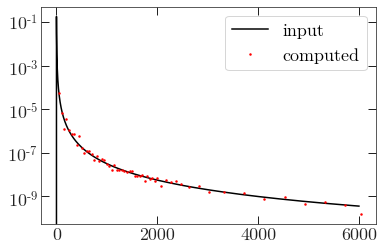

In [10]:
plt.plot(ps, 'k-', label='input')
plt.plot(Cb['ell'], Cb['TT'], 'r.', label='computed')
plt.legend()
plt.yscale('log')